In [68]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import os
import seaborn as sns

from keras.layers import LSTM,Dense,Dropout,Activation,GRU
from keras.models import Sequential
from tensorflow import keras

In [2]:
# df=pd.read_csv("municipality_bus_utilization.csv",index_col="timestamp")
df=pd.read_csv("municipality_bus_utilization.csv")
df.head()

,timestamp,municipality_id,usage,total_capacity
0,2017-06-04 07:59:42,9,454,1332
1,2017-06-04 07:59:42,8,556,2947
2,2017-06-04 07:59:42,4,1090,3893
3,2017-06-04 07:59:42,0,204,2813
4,2017-06-04 07:59:42,7,718,2019


In [3]:
bus_number=len(df.municipality_id.unique())
print("Total bus number:",bus_number)

Total bus number: 10


In [4]:
bus_df=[ f"df_bus{i}" for i in range(bus_number)]
print("9 different bus dataframes for 9 buses")
print(bus_df)

9 different bus dataframes for 9 buses
['df_bus0', 'df_bus1', 'df_bus2', 'df_bus3', 'df_bus4', 'df_bus5', 'df_bus6', 'df_bus7', 'df_bus8', 'df_bus9']


In [5]:
for no,bus in enumerate(bus_df):
    globals()[bus]=df[df["municipality_id"]==no].copy()

In [6]:
# Check first bus of head 5
df_bus0.head(5)

,timestamp,municipality_id,usage,total_capacity
3,2017-06-04 07:59:42,0,204,2813
18,2017-06-04 08:25:42,0,247,2813
29,2017-06-04 08:59:42,0,332,2813
34,2017-06-04 09:32:46,0,429,2813
47,2017-06-04 09:59:48,0,485,2813


In [7]:
# Check first bus of tail 5
df_bus0.tail(5)

,timestamp,municipality_id,usage,total_capacity
13024,2017-08-19 14:30:33,0,1285,2813
13031,2017-08-19 15:03:34,0,1283,2813
13041,2017-08-19 15:29:33,0,1286,2813
13059,2017-08-19 16:03:35,0,1276,2813
13062,2017-08-19 16:30:35,0,1271,2813


In [8]:
for i in bus_df:
    globals()[i].drop(["municipality_id","total_capacity"],axis=1,inplace=True)
    globals()[i].reset_index(drop=True,inplace=True)

In [9]:
# Check first bus of head 5 after Drop
df_bus0.head(5)

,timestamp,usage
0,2017-06-04 07:59:42,204
1,2017-06-04 08:25:42,247
2,2017-06-04 08:59:42,332
3,2017-06-04 09:32:46,429
4,2017-06-04 09:59:48,485


In [21]:
last_two_week_index=[]
for df_i in bus_df:
    par=globals()[df_i][globals()[df_i]["timestamp"].apply(lambda x: x[:].split()[0])=="2017-08-05" ].index[0]
    last_two_week_index.append(par)
    globals()[df_i].drop("timestamp",axis=1,inplace=True)
print("Index of last two weeks for all busses:",last_two_week_index)
# it seems that all index values are the same for the last two weeks

Index of last two weeks for all busses: [1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039]


In [40]:
print("Checking missing values in usage data")
for no,df_i in enumerate(bus_df):
    print(f" \n Bus{no+1}",globals()[df_i].isnull().sum())

Checking missing values in usage data
 
 Bus1 usage    0
dtype: int64
 
 Bus2 usage    0
dtype: int64
 
 Bus3 usage    0
dtype: int64
 
 Bus4 usage    0
dtype: int64
 
 Bus5 usage    0
dtype: int64
 
 Bus6 usage    0
dtype: int64
 
 Bus7 usage    0
dtype: int64
 
 Bus8 usage    0
dtype: int64
 
 Bus9 usage    0
dtype: int64
 
 Bus10 usage    0
dtype: int64


In [41]:
# Check first bus of head 5 after Drop timestamp
df_bus0.head(5)

,usage
0,204
1,247
2,332
3,429
4,485


In [23]:
train_size=1039

Usage of 10 buses in plot


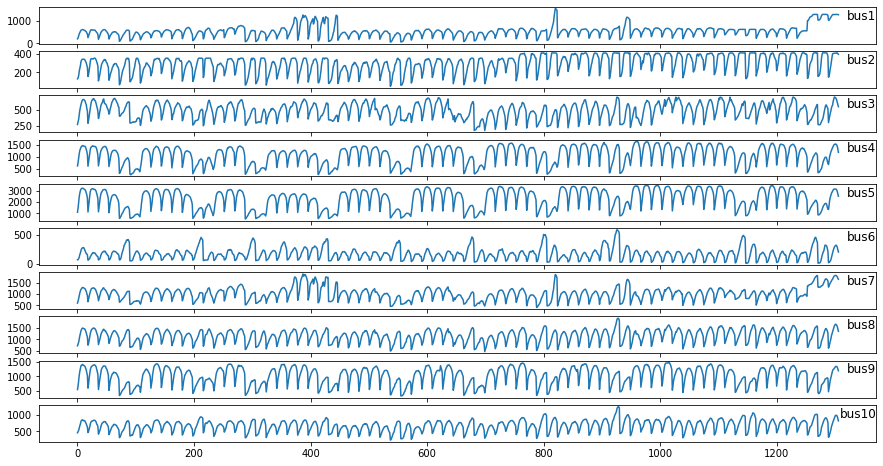

In [42]:
i=1
plt.figure(figsize=(15,8))
print("Usage of 10 buses in plot")
for no,bus in enumerate(bus_df):
    plt.subplot(len(bus_df),1,i)
    plt.plot(globals() [bus]["usage"])
    plt.title(f"bus{no+1}",y=0.5,loc="right")
    i+=1
plt.show()

In [43]:
train_df=[ f"train_bus{i}" for i in range(bus_number)]
test_df=[ f"test_bus{i}" for i in range(bus_number)]
print(train_df)
print(test_df)

['train_bus0', 'train_bus1', 'train_bus2', 'train_bus3', 'train_bus4', 'train_bus5', 'train_bus6', 'train_bus7', 'train_bus8', 'train_bus9']
['test_bus0', 'test_bus1', 'test_bus2', 'test_bus3', 'test_bus4', 'test_bus5', 'test_bus6', 'test_bus7', 'test_bus8', 'test_bus9']


In [46]:
for train_i,test_i,df_i in zip(train_df,test_df,bus_df):
    globals()[train_i]=globals()[df_i][:train_size]
    globals()[test_i]=globals()[df_i][train_size:]

In [50]:
train_bus0.shape, test_bus0.shape

((1039, 1), (268, 1))

### From here, Models will be built for each bus using LSTM

In [ ]:
## BUS0
from sklearn.preprocessing import MinMaxScaler
time_step=20
train_size=train_bus0.shape[0]
scaler=MinMaxScaler()
scaled_train_set=scaler.fit_transform(train_bus0)

# Creating a data structure with 20 time-steps and 1 output
X_train = []
y_train = []
for i in range(time_step,train_size):
    X_train.append(scaled_train_set[i-time_step:i, 0])
    y_train.append(scaled_train_set[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape,y_train.shape

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#(786, time_step, 1)
X_train.shape,y_train.shape

In [70]:
## BUS0

model = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 80,return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.3))

# Adding the second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 40))
model.add(Dropout(0.3))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling Model
model.compile(optimizer = "adam", loss = 'mean_squared_error')
# Fitting Model to the Training set
model.fit(X_train, y_train, epochs = 150, batch_size =32)

Epoch 1/150
32/32 [==============================] - 4s 20ms/step - loss: 0.0380
Epoch 2/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0202
Epoch 3/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0201
Epoch 4/150
32/32 [==============================] - 1s 20ms/step - loss: 0.0185
Epoch 5/150
32/32 [==============================] - 1s 20ms/step - loss: 0.0171
Epoch 6/150
32/32 [==============================] - 1s 20ms/step - loss: 0.0150
Epoch 7/150
32/32 [==============================] - 1s 20ms/step - loss: 0.0123
Epoch 8/150
32/32 [==============================] - 1s 22ms/step - loss: 0.0115
Epoch 9/150
32/32 [==============================] - 1s 22ms/step - loss: 0.0102
Epoch 10/150
32/32 [==============================] - 1s 22ms/step - loss: 0.0098
Epoch 11/150
32/32 [==============================] - 1s 24ms/step - loss: 0.0097
Epoch 12/150
32/32 [==============================] - 1s 24ms/step - loss: 0.0100
Epoch 13/150
32/32 [=====

32/32 [==============================] - 1s 18ms/step - loss: 0.0041
Epoch 102/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0046
Epoch 103/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0044
Epoch 104/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0042
Epoch 105/150
32/32 [==============================] - 1s 21ms/step - loss: 0.0044
Epoch 106/150
32/32 [==============================] - 1s 21ms/step - loss: 0.0038
Epoch 107/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0044
Epoch 108/150
32/32 [==============================] - 1s 21ms/step - loss: 0.0046
Epoch 109/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0038
Epoch 110/150
32/32 [==============================] - 1s 17ms/step - loss: 0.0041
Epoch 111/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0037
Epoch 112/150
32/32 [==============================] - 1s 17ms/step - loss: 0.0039
Epoch 113/150
32/3

In [71]:
## BUS1

time_step=20
train_size=train_bus1.shape[0]
scaler=MinMaxScaler()
scaled_train_set=scaler.fit_transform(train_bus1)

# Creating a data structure with 20 time-steps and 1 output
X_train = []
y_train = []
for i in range(time_step,train_size):
    X_train.append(scaled_train_set[i-time_step:i, 0])
    y_train.append(scaled_train_set[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape,y_train.shape

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#(786, time_step, 1)
X_train.shape,y_train.shape

model1 = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
model1.add(LSTM(units = 80,return_sequences = True, input_shape = (X_train.shape[1], 1)))
model1.add(Dropout(0.3))

# Adding the second LSTM layer and some Dropout regularisation
model1.add(LSTM(units = 40))
model1.add(Dropout(0.3))

# Adding the output layer
model1.add(Dense(units = 1))

# Compiling Model
model1.compile(optimizer = "adam", loss = 'mean_squared_error')
# Fitting Model to the Training set
model1.fit(X_train, y_train, epochs = 150, batch_size =32)

Epoch 1/150
32/32 [==============================] - 4s 20ms/step - loss: 0.1060
Epoch 2/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0675
Epoch 3/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0604
Epoch 4/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0512
Epoch 5/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0358
Epoch 6/150
32/32 [==============================] - 1s 20ms/step - loss: 0.0293
Epoch 7/150
32/32 [==============================] - 1s 21ms/step - loss: 0.0280
Epoch 8/150
32/32 [==============================] - 1s 21ms/step - loss: 0.0256
Epoch 9/150
32/32 [==============================] - 1s 21ms/step - loss: 0.0260
Epoch 10/150
32/32 [==============================] - 1s 20ms/step - loss: 0.0261
Epoch 11/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0262
Epoch 12/150
32/32 [==============================] - 1s 20ms/step - loss: 0.0246
Epoch 13/150
32/32 [=====

32/32 [==============================] - 1s 19ms/step - loss: 0.0066
Epoch 102/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0069
Epoch 103/150
32/32 [==============================] - 1s 20ms/step - loss: 0.0068
Epoch 104/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0067
Epoch 105/150
32/32 [==============================] - 1s 20ms/step - loss: 0.0060
Epoch 106/150
32/32 [==============================] - 1s 22ms/step - loss: 0.0064
Epoch 107/150
32/32 [==============================] - 1s 20ms/step - loss: 0.0068
Epoch 108/150
32/32 [==============================] - 1s 20ms/step - loss: 0.0066
Epoch 109/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0062
Epoch 110/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0060
Epoch 111/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0060
Epoch 112/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0055
Epoch 113/150
32/3

In [72]:
## BUS2
time_step=20
train_size=train_bus2.shape[0]
scaler=MinMaxScaler()
scaled_train_set=scaler.fit_transform(train_bus2)

# Creating a data structure with 20 time-steps and 1 output
X_train = []
y_train = []
for i in range(time_step,train_size):
    X_train.append(scaled_train_set[i-time_step:i, 0])
    y_train.append(scaled_train_set[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape,y_train.shape

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#(786, time_step, 1)
X_train.shape,y_train.shape

model2 = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
model2.add(LSTM(units = 80,return_sequences = True, input_shape = (X_train.shape[1], 1)))
model2.add(Dropout(0.3))

# Adding the second LSTM layer and some Dropout regularisation
model2.add(LSTM(units = 40))
model2.add(Dropout(0.3))

# Adding the output layer
model2.add(Dense(units = 1))

# Compiling Model
model2.compile(optimizer = "adam", loss = 'mean_squared_error')
# Fitting Model to the Training set
model2.fit(X_train, y_train, epochs = 150, batch_size =32)

Epoch 1/150
32/32 [==============================] - 4s 20ms/step - loss: 0.0862
Epoch 2/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0507
Epoch 3/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0466
Epoch 4/150
32/32 [==============================] - 1s 23ms/step - loss: 0.0435
Epoch 5/150
32/32 [==============================] - 1s 20ms/step - loss: 0.0330
Epoch 6/150
32/32 [==============================] - 1s 20ms/step - loss: 0.0289
Epoch 7/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0243
Epoch 8/150
32/32 [==============================] - 1s 20ms/step - loss: 0.0226
Epoch 9/150
32/32 [==============================] - 1s 22ms/step - loss: 0.0223
Epoch 10/150
32/32 [==============================] - 1s 20ms/step - loss: 0.0231
Epoch 11/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0216
Epoch 12/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0214
Epoch 13/150
32/32 [=====

32/32 [==============================] - 1s 19ms/step - loss: 0.0079
Epoch 102/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0075
Epoch 103/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0078
Epoch 104/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0083
Epoch 105/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0078
Epoch 106/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0083
Epoch 107/150
32/32 [==============================] - 1s 22ms/step - loss: 0.0075
Epoch 108/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0079
Epoch 109/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0082
Epoch 110/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0078
Epoch 111/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0072
Epoch 112/150
32/32 [==============================] - 1s 20ms/step - loss: 0.0073
Epoch 113/150
32/3

In [73]:
## BUS3
time_step=20
train_size=train_bus3.shape[0]
scaler=MinMaxScaler()
scaled_train_set=scaler.fit_transform(train_bus3)

# Creating a data structure with 20 time-steps and 1 output
X_train = []
y_train = []
for i in range(time_step,train_size):
    X_train.append(scaled_train_set[i-time_step:i, 0])
    y_train.append(scaled_train_set[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape,y_train.shape

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#(786, time_step, 1)
X_train.shape,y_train.shape

model3 = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
model3.add(LSTM(units = 80,return_sequences = True, input_shape = (X_train.shape[1], 1)))
model3.add(Dropout(0.3))

# Adding the second LSTM layer and some Dropout regularisation
model3.add(LSTM(units = 40))
model3.add(Dropout(0.3))

# Adding the output layer
model3.add(Dense(units = 1))

# Compiling Model
model3.compile(optimizer = "adam", loss = 'mean_squared_error')
# Fitting Model to the Training set
model3.fit(X_train, y_train, epochs = 150, batch_size =32)

Epoch 1/150
32/32 [==============================] - 4s 20ms/step - loss: 0.1136
Epoch 2/150
32/32 [==============================] - 1s 24ms/step - loss: 0.0586
Epoch 3/150
32/32 [==============================] - 1s 21ms/step - loss: 0.0564
Epoch 4/150
32/32 [==============================] - 1s 21ms/step - loss: 0.0532
Epoch 5/150
32/32 [==============================] - 1s 20ms/step - loss: 0.0485
Epoch 6/150
32/32 [==============================] - 1s 20ms/step - loss: 0.0431
Epoch 7/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0349
Epoch 8/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0302
Epoch 9/150
32/32 [==============================] - 1s 20ms/step - loss: 0.0287
Epoch 10/150
32/32 [==============================] - 1s 22ms/step - loss: 0.0289
Epoch 11/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0277
Epoch 12/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0258
Epoch 13/150
32/32 [=====

32/32 [==============================] - 1s 23ms/step - loss: 0.0059
Epoch 102/150
32/32 [==============================] - 1s 20ms/step - loss: 0.0055
Epoch 103/150
32/32 [==============================] - 1s 22ms/step - loss: 0.0052
Epoch 104/150
32/32 [==============================] - 1s 22ms/step - loss: 0.0051
Epoch 105/150
32/32 [==============================] - 1s 20ms/step - loss: 0.0052
Epoch 106/150
32/32 [==============================] - 1s 20ms/step - loss: 0.0050
Epoch 107/150
32/32 [==============================] - 1s 21ms/step - loss: 0.0054
Epoch 108/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0052
Epoch 109/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0048
Epoch 110/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0050
Epoch 111/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0049
Epoch 112/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0051
Epoch 113/150
32/3

In [74]:
## BUS4
time_step=20
train_size=train_bus4.shape[0]
scaler=MinMaxScaler()
scaled_train_set=scaler.fit_transform(train_bus4)

# Creating a data structure with 20 time-steps and 1 output
X_train = []
y_train = []
for i in range(time_step,train_size):
    X_train.append(scaled_train_set[i-time_step:i, 0])
    y_train.append(scaled_train_set[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape,y_train.shape

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#(786, time_step, 1)
X_train.shape,y_train.shape

model4 = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
model4.add(LSTM(units = 80,return_sequences = True, input_shape = (X_train.shape[1], 1)))
model4.add(Dropout(0.3))

# Adding the second LSTM layer and some Dropout regularisation
model4.add(LSTM(units = 40))
model4.add(Dropout(0.3))

# Adding the output layer
model4.add(Dense(units = 1))

# Compiling Model
model4.compile(optimizer = "adam", loss = 'mean_squared_error')
# Fitting Model to the Training set
model4.fit(X_train, y_train, epochs = 150, batch_size =32)

Epoch 1/150
32/32 [==============================] - 4s 19ms/step - loss: 0.1038
Epoch 2/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0580
Epoch 3/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0545
Epoch 4/150
32/32 [==============================] - 1s 21ms/step - loss: 0.0494
Epoch 5/150
32/32 [==============================] - 1s 20ms/step - loss: 0.0463
Epoch 6/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0369
Epoch 7/150
32/32 [==============================] - 1s 21ms/step - loss: 0.0334
Epoch 8/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0302
Epoch 9/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0279
Epoch 10/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0274
Epoch 11/150
32/32 [==============================] - 1s 22ms/step - loss: 0.0268
Epoch 12/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0267
Epoch 13/150
32/32 [=====

32/32 [==============================] - 1s 23ms/step - loss: 0.0047
Epoch 102/150
32/32 [==============================] - 1s 20ms/step - loss: 0.0052
Epoch 103/150
32/32 [==============================] - 1s 21ms/step - loss: 0.0052
Epoch 104/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0050
Epoch 105/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0044
Epoch 106/150
32/32 [==============================] - 1s 22ms/step - loss: 0.0049
Epoch 107/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0046
Epoch 108/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0044
Epoch 109/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0046
Epoch 110/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0045
Epoch 111/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0043
Epoch 112/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0046
Epoch 113/150
32/3

In [75]:
## BUS5
time_step=20
train_size=train_bus5.shape[0]
scaler=MinMaxScaler()
scaled_train_set=scaler.fit_transform(train_bus5)

# Creating a data structure with 20 time-steps and 1 output
X_train = []
y_train = []
for i in range(time_step,train_size):
    X_train.append(scaled_train_set[i-time_step:i, 0])
    y_train.append(scaled_train_set[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape,y_train.shape

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#(786, time_step, 1)
X_train.shape,y_train.shape

model5 = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
model5.add(LSTM(units = 80,return_sequences = True, input_shape = (X_train.shape[1], 1)))
model5.add(Dropout(0.3))

# Adding the second LSTM layer and some Dropout regularisation
model5.add(LSTM(units = 40))
model5.add(Dropout(0.3))

# Adding the output layer
model5.add(Dense(units = 1))

# Compiling Model
model5.compile(optimizer = "adam", loss = 'mean_squared_error')
# Fitting Model to the Training set
model5.fit(X_train, y_train, epochs = 150, batch_size =32)

Epoch 1/150
32/32 [==============================] - 4s 19ms/step - loss: 0.0403
Epoch 2/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0292
Epoch 3/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0237
Epoch 4/150
32/32 [==============================] - 1s 25ms/step - loss: 0.0152
Epoch 5/150
32/32 [==============================] - 1s 22ms/step - loss: 0.0123
Epoch 6/150
32/32 [==============================] - 1s 20ms/step - loss: 0.0112
Epoch 7/150
32/32 [==============================] - 1s 21ms/step - loss: 0.0110
Epoch 8/150
32/32 [==============================] - 1s 21ms/step - loss: 0.0098
Epoch 9/150
32/32 [==============================] - 1s 27ms/step - loss: 0.0095
Epoch 10/150
32/32 [==============================] - 1s 24ms/step - loss: 0.0094
Epoch 11/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0083
Epoch 12/150
32/32 [==============================] - 1s 31ms/step - loss: 0.0081
Epoch 13/150
32/32 [=====

32/32 [==============================] - 1s 19ms/step - loss: 0.0033
Epoch 102/150
32/32 [==============================] - 1s 17ms/step - loss: 0.0029
Epoch 103/150
32/32 [==============================] - 1s 23ms/step - loss: 0.0024
Epoch 104/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0030
Epoch 105/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0034
Epoch 106/150
32/32 [==============================] - 1s 20ms/step - loss: 0.0028
Epoch 107/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0026
Epoch 108/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0029
Epoch 109/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0025
Epoch 110/150
32/32 [==============================] - 1s 23ms/step - loss: 0.0025
Epoch 111/150
32/32 [==============================] - 1s 21ms/step - loss: 0.0024
Epoch 112/150
32/32 [==============================] - 1s 22ms/step - loss: 0.0027
Epoch 113/150
32/3

In [76]:
## BUS6
time_step=20
train_size=train_bus6.shape[0]
scaler=MinMaxScaler()
scaled_train_set=scaler.fit_transform(train_bus6)

# Creating a data structure with 20 time-steps and 1 output
X_train = []
y_train = []
for i in range(time_step,train_size):
    X_train.append(scaled_train_set[i-time_step:i, 0])
    y_train.append(scaled_train_set[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape,y_train.shape

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#(786, time_step, 1)
X_train.shape,y_train.shape

model6 = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
model6.add(LSTM(units = 80,return_sequences = True, input_shape = (X_train.shape[1], 1)))
model6.add(Dropout(0.3))

# Adding the second LSTM layer and some Dropout regularisation
model6.add(LSTM(units = 40))
model6.add(Dropout(0.3))

# Adding the output layer
model6.add(Dense(units = 1))

# Compiling Model
model6.compile(optimizer = "adam", loss = 'mean_squared_error')
# Fitting Model to the Training set
model6.fit(X_train, y_train, epochs = 150, batch_size =32)

Epoch 1/150
32/32 [==============================] - 4s 19ms/step - loss: 0.0398
Epoch 2/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0313
Epoch 3/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0269
Epoch 4/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0237
Epoch 5/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0174
Epoch 6/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0150
Epoch 7/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0143
Epoch 8/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0137
Epoch 9/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0147
Epoch 10/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0134
Epoch 11/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0129
Epoch 12/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0127
Epoch 13/150
32/32 [=====

32/32 [==============================] - 1s 18ms/step - loss: 0.0051
Epoch 102/150
32/32 [==============================] - 1s 17ms/step - loss: 0.0048
Epoch 103/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0052
Epoch 104/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0053
Epoch 105/150
32/32 [==============================] - 1s 17ms/step - loss: 0.0050
Epoch 106/150
32/32 [==============================] - 1s 17ms/step - loss: 0.0053
Epoch 107/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0049
Epoch 108/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0048
Epoch 109/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0055
Epoch 110/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0051
Epoch 111/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0045
Epoch 112/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0047
Epoch 113/150
32/3

In [77]:
## BUS7
time_step=20
train_size=train_bus7.shape[0]
scaler=MinMaxScaler()
scaled_train_set=scaler.fit_transform(train_bus7)

# Creating a data structure with 20 time-steps and 1 output
X_train = []
y_train = []
for i in range(time_step,train_size):
    X_train.append(scaled_train_set[i-time_step:i, 0])
    y_train.append(scaled_train_set[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape,y_train.shape

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#(786, time_step, 1)
X_train.shape,y_train.shape

model7 = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
model7.add(LSTM(units = 80,return_sequences = True, input_shape = (X_train.shape[1], 1)))
model7.add(Dropout(0.3))

# Adding the second LSTM layer and some Dropout regularisation
model7.add(LSTM(units = 40))
model7.add(Dropout(0.3))

# Adding the output layer
model7.add(Dense(units = 1))

# Compiling Model
model7.compile(optimizer = "adam", loss = 'mean_squared_error')
# Fitting Model to the Training set
model7.fit(X_train, y_train, epochs = 150, batch_size =32)

Epoch 1/150
32/32 [==============================] - 3s 19ms/step - loss: 0.0645
Epoch 2/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0373
Epoch 3/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0338
Epoch 4/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0295
Epoch 5/150
32/32 [==============================] - 1s 20ms/step - loss: 0.0228
Epoch 6/150
32/32 [==============================] - 1s 20ms/step - loss: 0.0154
Epoch 7/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0151
Epoch 8/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0146
Epoch 9/150
32/32 [==============================] - 1s 21ms/step - loss: 0.0139
Epoch 10/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0137
Epoch 11/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0135
Epoch 12/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0128
Epoch 13/150
32/32 [=====

32/32 [==============================] - 1s 18ms/step - loss: 0.0036
Epoch 102/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0032
Epoch 103/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0034
Epoch 104/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0032
Epoch 105/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0031
Epoch 106/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0032
Epoch 107/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0031
Epoch 108/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0033
Epoch 109/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0030
Epoch 110/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0029
Epoch 111/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0031
Epoch 112/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0030
Epoch 113/150
32/3

In [78]:
## BUS8
time_step=20
train_size=train_bus8.shape[0]
scaler=MinMaxScaler()
scaled_train_set=scaler.fit_transform(train_bus8)

# Creating a data structure with 20 time-steps and 1 output
X_train = []
y_train = []
for i in range(time_step,train_size):
    X_train.append(scaled_train_set[i-time_step:i, 0])
    y_train.append(scaled_train_set[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape,y_train.shape

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#(786, time_step, 1)
X_train.shape,y_train.shape

model8 = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
model8.add(LSTM(units = 80,return_sequences = True, input_shape = (X_train.shape[1], 1)))
model8.add(Dropout(0.3))

# Adding the second LSTM layer and some Dropout regularisation
model8.add(LSTM(units = 40))
model8.add(Dropout(0.3))

# Adding the output layer
model8.add(Dense(units = 1))

# Compiling Model
model8.compile(optimizer = "adam", loss = 'mean_squared_error')
# Fitting Model to the Training set
model8.fit(X_train, y_train, epochs = 150, batch_size =32)

Epoch 1/150
32/32 [==============================] - 4s 19ms/step - loss: 0.1010
Epoch 2/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0578
Epoch 3/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0555
Epoch 4/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0486
Epoch 5/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0412
Epoch 6/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0318
Epoch 7/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0311
Epoch 8/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0306
Epoch 9/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0273
Epoch 10/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0262
Epoch 11/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0280
Epoch 12/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0264
Epoch 13/150
32/32 [=====

32/32 [==============================] - 1s 20ms/step - loss: 0.0058
Epoch 102/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0056
Epoch 103/150
32/32 [==============================] - 1s 17ms/step - loss: 0.0056
Epoch 104/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0055
Epoch 105/150
32/32 [==============================] - 1s 17ms/step - loss: 0.0054
Epoch 106/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0055
Epoch 107/150
32/32 [==============================] - 1s 17ms/step - loss: 0.0052
Epoch 108/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0053
Epoch 109/150
32/32 [==============================] - 1s 17ms/step - loss: 0.0059
Epoch 110/150
32/32 [==============================] - 1s 17ms/step - loss: 0.0052
Epoch 111/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0049
Epoch 112/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0048
Epoch 113/150
32/3

In [79]:
## BUS9
time_step=20
train_size=train_bus9.shape[0]
scaler=MinMaxScaler()
scaled_train_set=scaler.fit_transform(train_bus9)

# Creating a data structure with 20 time-steps and 1 output
X_train = []
y_train = []
for i in range(time_step,train_size):
    X_train.append(scaled_train_set[i-time_step:i, 0])
    y_train.append(scaled_train_set[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape,y_train.shape

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#(786, time_step, 1)
X_train.shape,y_train.shape

model9 = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
model9.add(LSTM(units = 80,return_sequences = True, input_shape = (X_train.shape[1], 1)))
model9.add(Dropout(0.3))

# Adding the second LSTM layer and some Dropout regularisation
model9.add(LSTM(units = 40))
model9.add(Dropout(0.3))

# Adding the output layer
model9.add(Dense(units = 1))

# Compiling Model
model9.compile(optimizer = "adam", loss = 'mean_squared_error')
# Fitting Model to the Training set
model9.fit(X_train, y_train, epochs = 150, batch_size =32)

Epoch 1/150
32/32 [==============================] - 4s 19ms/step - loss: 0.0542
Epoch 2/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0309
Epoch 3/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0271
Epoch 4/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0217
Epoch 5/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0154
Epoch 6/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0133
Epoch 7/150
32/32 [==============================] - 1s 20ms/step - loss: 0.0129
Epoch 8/150
32/32 [==============================] - 1s 21ms/step - loss: 0.0124
Epoch 9/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0119
Epoch 10/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0114
Epoch 11/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0109
Epoch 12/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0109
Epoch 13/150
32/32 [=====

32/32 [==============================] - 1s 19ms/step - loss: 0.0033
Epoch 102/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0029
Epoch 103/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0029
Epoch 104/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0029
Epoch 105/150
32/32 [==============================] - 1s 18ms/step - loss: 0.0029
Epoch 106/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0030
Epoch 107/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0029
Epoch 108/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0027
Epoch 109/150
32/32 [==============================] - 1s 25ms/step - loss: 0.0028
Epoch 110/150
32/32 [==============================] - 1s 21ms/step - loss: 0.0026
Epoch 111/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0028
Epoch 112/150
32/32 [==============================] - 1s 19ms/step - loss: 0.0027
Epoch 113/150
32/3

In [80]:
losses0=pd.DataFrame(model.history.history['loss'])
losses1=pd.DataFrame(model1.history.history['loss'])
losses2=pd.DataFrame(model2.history.history['loss'])
losses3=pd.DataFrame(model3.history.history['loss'])
losses4=pd.DataFrame(model4.history.history['loss'])
losses5=pd.DataFrame(model5.history.history['loss'])
losses6=pd.DataFrame(model6.history.history['loss'])
losses7=pd.DataFrame(model7.history.history['loss'])
losses8=pd.DataFrame(model8.history.history['loss'])
losses9=pd.DataFrame(model9.history.history['loss'])

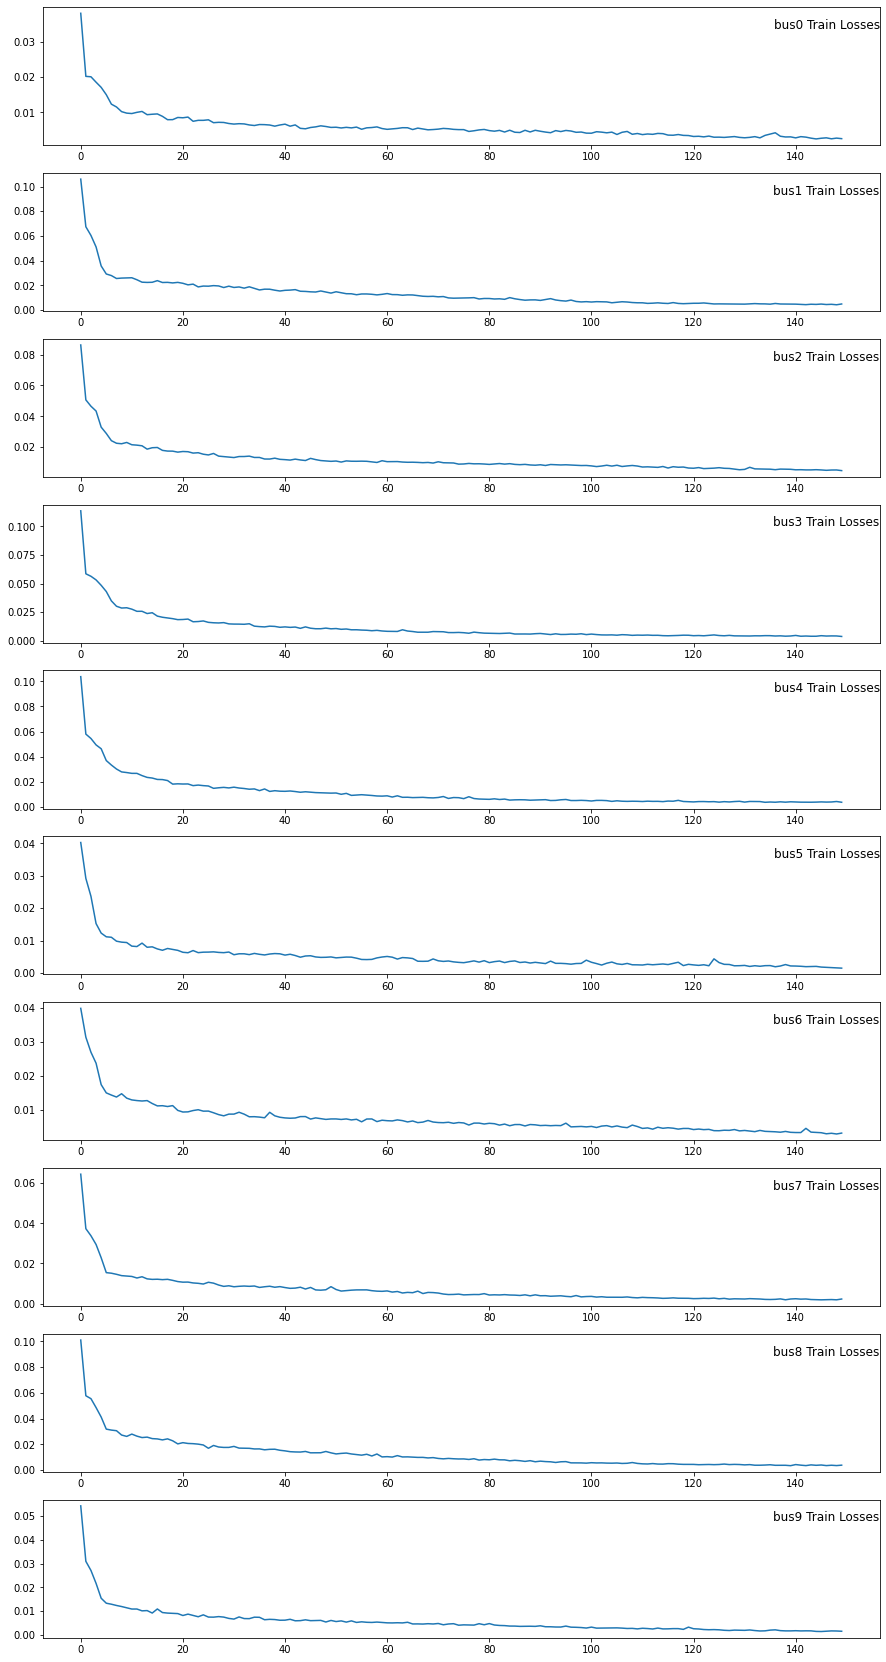

In [138]:
plt.figure(figsize=(15,30))
# ------------------------------------
plt.subplot(len(bus_df),1,1)
plt.plot(losses0)
plt.title(f"bus{0} Train Losses",y=0.8,loc="right")
# ------------------------------------
plt.subplot(len(bus_df),1,2)
plt.plot(losses1)
plt.title(f"bus{1} Train Losses",y=0.8,loc="right")
# ------------------------------------
plt.subplot(len(bus_df),1,3)
plt.plot(losses2)
plt.title(f"bus{2} Train Losses",y=0.8,loc="right")
# ------------------------------------
plt.subplot(len(bus_df),1,4)
plt.plot(losses3)
plt.title(f"bus{3} Train Losses",y=0.8,loc="right")
# ------------------------------------
plt.subplot(len(bus_df),1,5)
plt.plot(losses4)
plt.title(f"bus{4} Train Losses",y=0.8,loc="right")
# ------------------------------------
plt.subplot(len(bus_df),1,6)
plt.plot(losses5)
plt.title(f"bus{5} Train Losses",y=0.8,loc="right")
# ------------------------------------
plt.subplot(len(bus_df),1,7)
plt.plot(losses6)
plt.title(f"bus{6} Train Losses",y=0.8,loc="right")
# ------------------------------------
plt.subplot(len(bus_df),1,8)
plt.plot(losses7)
plt.title(f"bus{7} Train Losses",y=0.8,loc="right")
# ------------------------------------
plt.subplot(len(bus_df),1,9)
plt.plot(losses8)
plt.title(f"bus{8} Train Losses",y=0.8,loc="right")
# ------------------------------------
plt.subplot(len(bus_df),1,10)
plt.plot(losses9)
plt.title(f"bus{9} Train Losses",y=0.8,loc="right")
# ------------------------------------
plt.show()

(268, 20, 1)
9/9 [==============================] - 0s 10ms/step


c:\users\developer\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


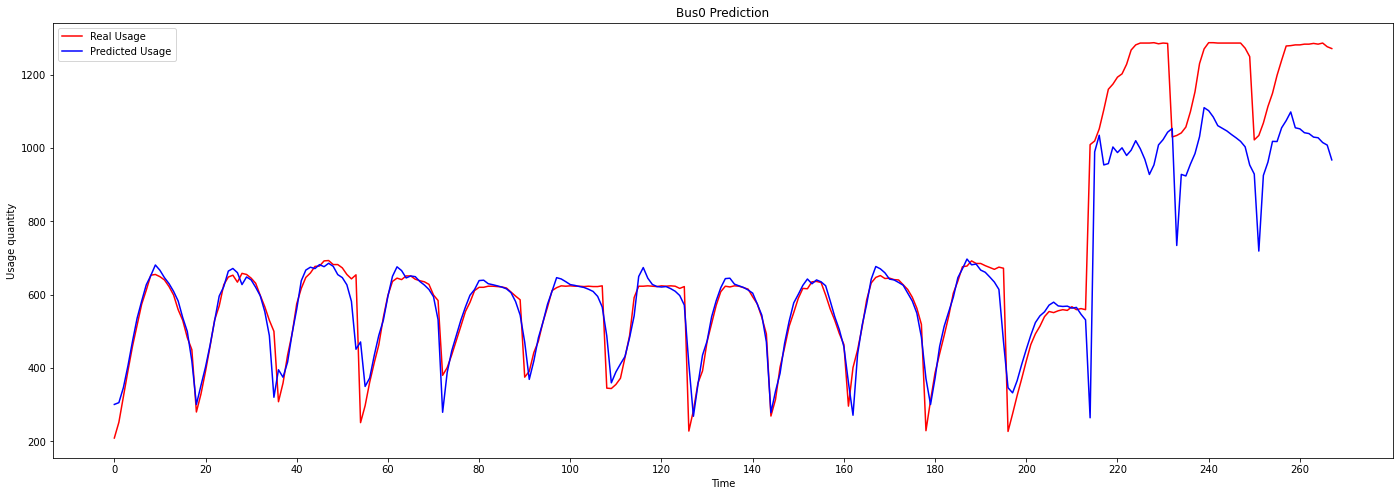

1/1 [==============================] - 0s 23ms/step


Text(0.5, 1.0, 'Bus0 Future Usage prediction')

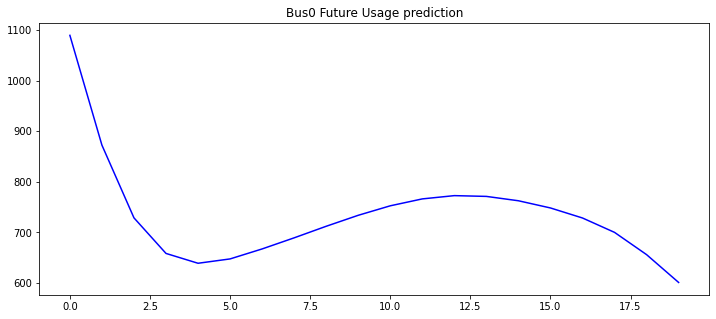

In [116]:
## BUS0
inputs = df_bus0[len(df_bus0) - len(test_bus0) - time_step:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
test_size=len(df_bus0)-len(train_bus0)
X_test = []
for i in range(time_step,(time_step+test_size)):
    X_test.append(inputs[i-time_step:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

predicted_usage_number0= model.predict(X_test)
predicted_usage_number0= scaler.inverse_transform(predicted_usage_number0)

# Visualising the results
plt.figure(figsize=(24,8))
plt.plot(test_bus0.values, color = "red", label ="Real Usage")
plt.plot(predicted_usage_number0, color = "blue", label = "Predicted Usage")
plt.xticks(np.arange(0,test_size,time_step))
plt.title('Bus0 Prediction')
plt.xlabel('Time')
plt.ylabel('Usage quantity')
plt.legend()
plt.show()

full_scaled_data=scaler.fit_transform(df_bus0)
forecast=[]
periods=20
n_features=1
first_eval_batch=full_scaled_data[-time_step:]
current_batch=first_eval_batch.reshape((1,time_step,n_features))

for i in range(periods):
    current_pred=model.predict(current_batch)[0]
    forecast.append(current_pred)
    current_batch=np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

forecast0=scaler.inverse_transform(forecast)
plt.figure(figsize=(12,5))
plt.plot(forecast0,color="blue")
plt.title("Bus0 Future Usage prediction")

(268, 20, 1)
5/9 [===============>..............] - ETA: 0s

c:\users\developer\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


9/9 [==============================] - 0s 13ms/step


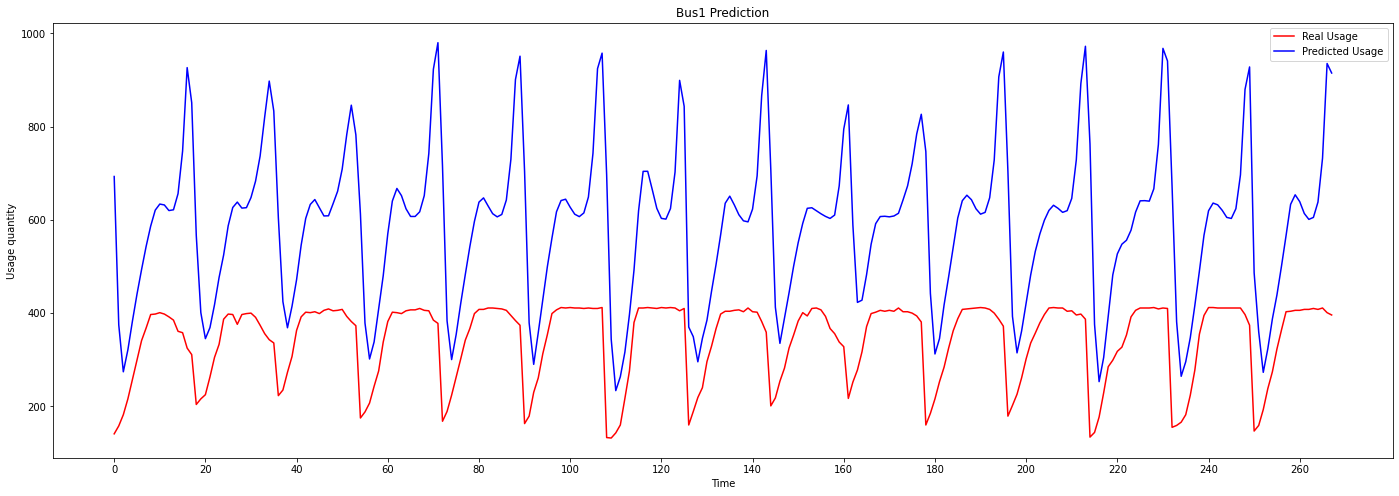

1/1 [==============================] - 0s 25ms/step


Text(0.5, 1.0, 'Bus1 Future Usage prediction')

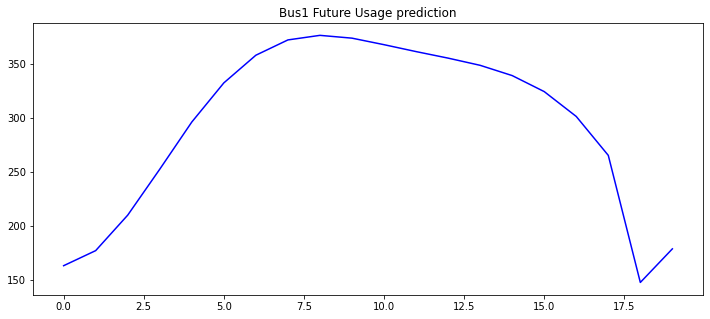

In [117]:
## BUS1
inputs = df_bus1[len(df_bus1) - len(test_bus1) - time_step:].values #*
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
test_size=len(df_bus1)-len(train_bus1) #*
X_test = []
for i in range(time_step,(time_step+test_size)):
    X_test.append(inputs[i-time_step:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

predicted_usage_number1= model1.predict(X_test) #*
predicted_usage_number1= scaler.inverse_transform(predicted_usage_number1) #*

# Visualising the results
plt.figure(figsize=(24,8))
plt.plot(test_bus1.values, color = "red", label ="Real Usage") #*
plt.plot(predicted_usage_number1, color = "blue", label = "Predicted Usage") #*
plt.xticks(np.arange(0,test_size,time_step))
plt.title('Bus1 Prediction') #*
plt.xlabel('Time')
plt.ylabel('Usage quantity')
plt.legend()
plt.show()

full_scaled_data=scaler.fit_transform(df_bus1) #*
forecast=[]
periods=20
n_features=1
first_eval_batch=full_scaled_data[-time_step:]
current_batch=first_eval_batch.reshape((1,time_step,n_features))

for i in range(periods):
    current_pred=model1.predict(current_batch)[0] #*
    forecast.append(current_pred)
    current_batch=np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

forecast1=scaler.inverse_transform(forecast)
plt.figure(figsize=(12,5))
plt.plot(forecast1,color="blue")
plt.title("Bus1 Future Usage prediction") #*

(268, 20, 1)
9/9 [==============================] - 0s 11ms/step


c:\users\developer\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


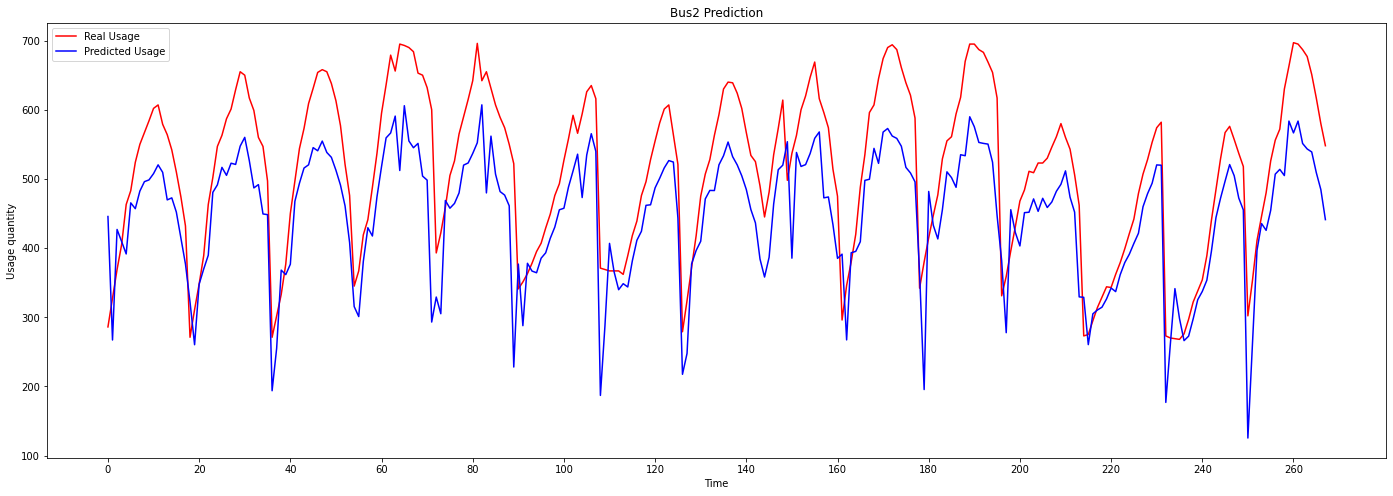

1/1 [==============================] - 0s 23ms/step


Text(0.5, 1.0, 'Bus2 Future Usage prediction')

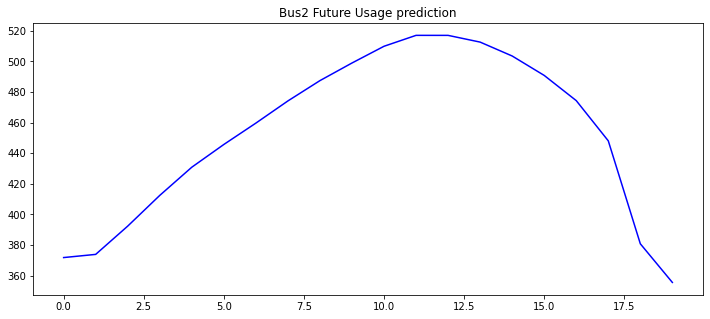

In [118]:
## BUS2
inputs = df_bus2[len(df_bus2) - len(test_bus2) - time_step:].values #*
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
test_size=len(df_bus2)-len(train_bus2) #*
X_test = []
for i in range(time_step,(time_step+test_size)):
    X_test.append(inputs[i-time_step:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

predicted_usage_number2= model2.predict(X_test) #*
predicted_usage_number2= scaler.inverse_transform(predicted_usage_number2) #*

# Visualising the results
plt.figure(figsize=(24,8))
plt.plot(test_bus2.values, color = "red", label ="Real Usage") #*
plt.plot(predicted_usage_number2, color = "blue", label = "Predicted Usage") #*
plt.xticks(np.arange(0,test_size,time_step))
plt.title('Bus2 Prediction') #*
plt.xlabel('Time')
plt.ylabel('Usage quantity')
plt.legend()
plt.show()

full_scaled_data=scaler.fit_transform(df_bus2) #*
forecast=[]
periods=20
n_features=1
first_eval_batch=full_scaled_data[-time_step:]
current_batch=first_eval_batch.reshape((1,time_step,n_features))

for i in range(periods):
    current_pred=model2.predict(current_batch)[0] #*
    forecast.append(current_pred)
    current_batch=np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

forecast2=scaler.inverse_transform(forecast)
plt.figure(figsize=(12,5))
plt.plot(forecast2,color="blue")
plt.title("Bus2 Future Usage prediction") #*

(268, 20, 1)
9/9 [==============================] - 0s 11ms/step


c:\users\developer\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


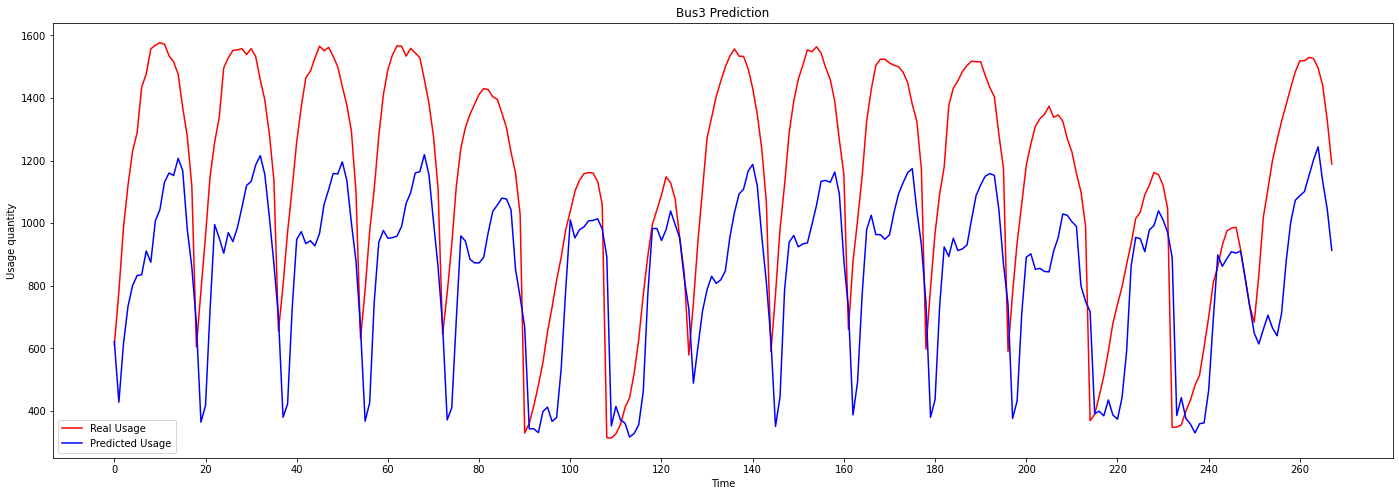

1/1 [==============================] - 0s 21ms/step


Text(0.5, 1.0, 'Bus3 Future Usage prediction')

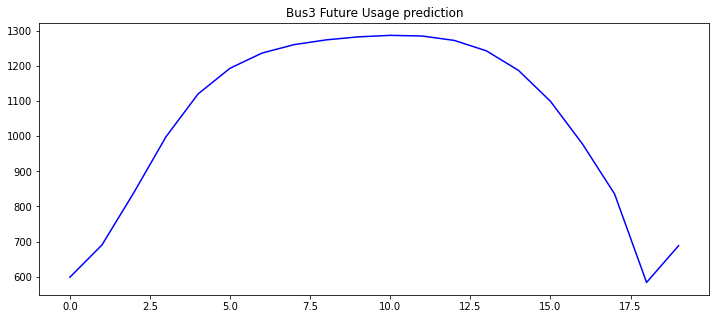

In [119]:
## BUS3
inputs = df_bus3[len(df_bus3) - len(test_bus3) - time_step:].values #*
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
test_size=len(df_bus3)-len(train_bus3) #*
X_test = []
for i in range(time_step,(time_step+test_size)):
    X_test.append(inputs[i-time_step:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

predicted_usage_number3= model3.predict(X_test) #*
predicted_usage_number3= scaler.inverse_transform(predicted_usage_number3) #*

# Visualising the results
plt.figure(figsize=(24,8))
plt.plot(test_bus3.values, color = "red", label ="Real Usage") #*
plt.plot(predicted_usage_number3, color = "blue", label = "Predicted Usage") #*
plt.xticks(np.arange(0,test_size,time_step))
plt.title('Bus3 Prediction') #*
plt.xlabel('Time')
plt.ylabel('Usage quantity')
plt.legend()
plt.show()

full_scaled_data=scaler.fit_transform(df_bus3) #*
forecast=[]
periods=20
n_features=1
first_eval_batch=full_scaled_data[-time_step:]
current_batch=first_eval_batch.reshape((1,time_step,n_features))

for i in range(periods):
    current_pred=model3.predict(current_batch)[0] #*
    forecast.append(current_pred)
    current_batch=np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

forecast3=scaler.inverse_transform(forecast)
plt.figure(figsize=(12,5))
plt.plot(forecast3,color="blue")
plt.title("Bus3 Future Usage prediction") #*

(268, 20, 1)
1/9 [==>...........................] - ETA: 0s

c:\users\developer\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


9/9 [==============================] - 0s 11ms/step


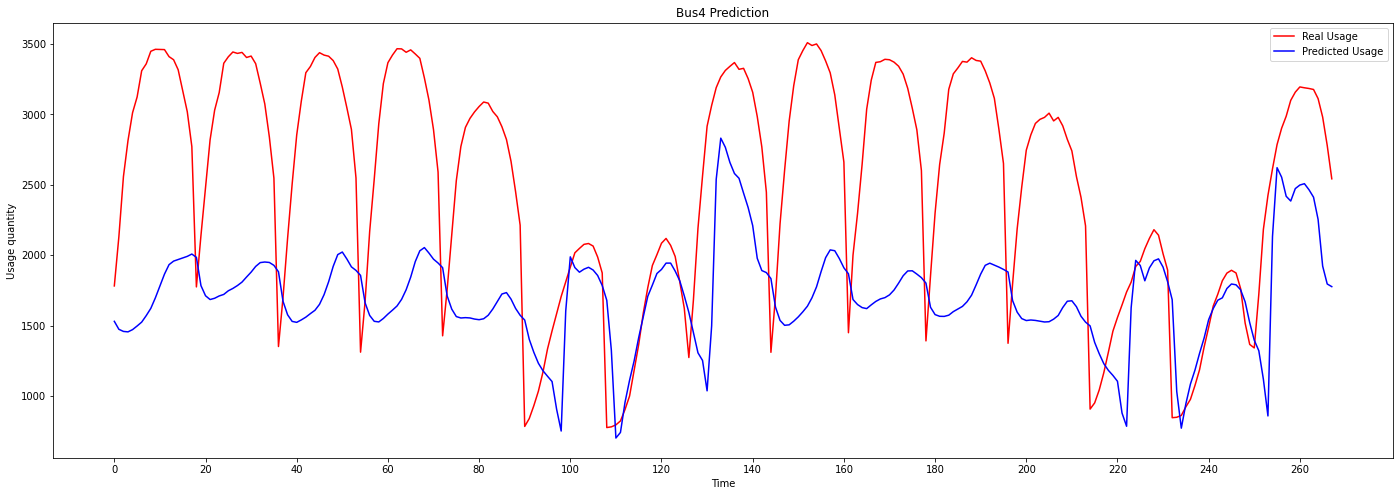

1/1 [==============================] - 0s 22ms/step


Text(0.5, 1.0, 'Bus4 Future Usage prediction')

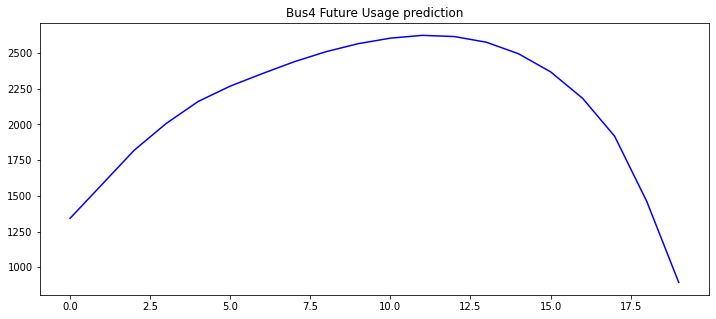

In [120]:
## BUS4
inputs = df_bus4[len(df_bus4) - len(test_bus4) - time_step:].values #*
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
test_size=len(df_bus4)-len(train_bus4) #*
X_test = []
for i in range(time_step,(time_step+test_size)):
    X_test.append(inputs[i-time_step:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

predicted_usage_number4= model4.predict(X_test) #*
predicted_usage_number4= scaler.inverse_transform(predicted_usage_number4) #*

# Visualising the results
plt.figure(figsize=(24,8))
plt.plot(test_bus4.values, color = "red", label ="Real Usage") #*
plt.plot(predicted_usage_number4, color = "blue", label = "Predicted Usage") #*
plt.xticks(np.arange(0,test_size,time_step))
plt.title('Bus4 Prediction') #*
plt.xlabel('Time')
plt.ylabel('Usage quantity')
plt.legend()
plt.show()

full_scaled_data=scaler.fit_transform(df_bus4) #*
forecast=[]
periods=20
n_features=1
first_eval_batch=full_scaled_data[-time_step:]
current_batch=first_eval_batch.reshape((1,time_step,n_features))

for i in range(periods):
    current_pred=model4.predict(current_batch)[0] #*
    forecast.append(current_pred)
    current_batch=np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

forecast4=scaler.inverse_transform(forecast)
plt.figure(figsize=(12,5))
plt.plot(forecast4,color="blue")
plt.title("Bus4 Future Usage prediction") #*

(268, 20, 1)
9/9 [==============================] - 0s 11ms/step


c:\users\developer\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


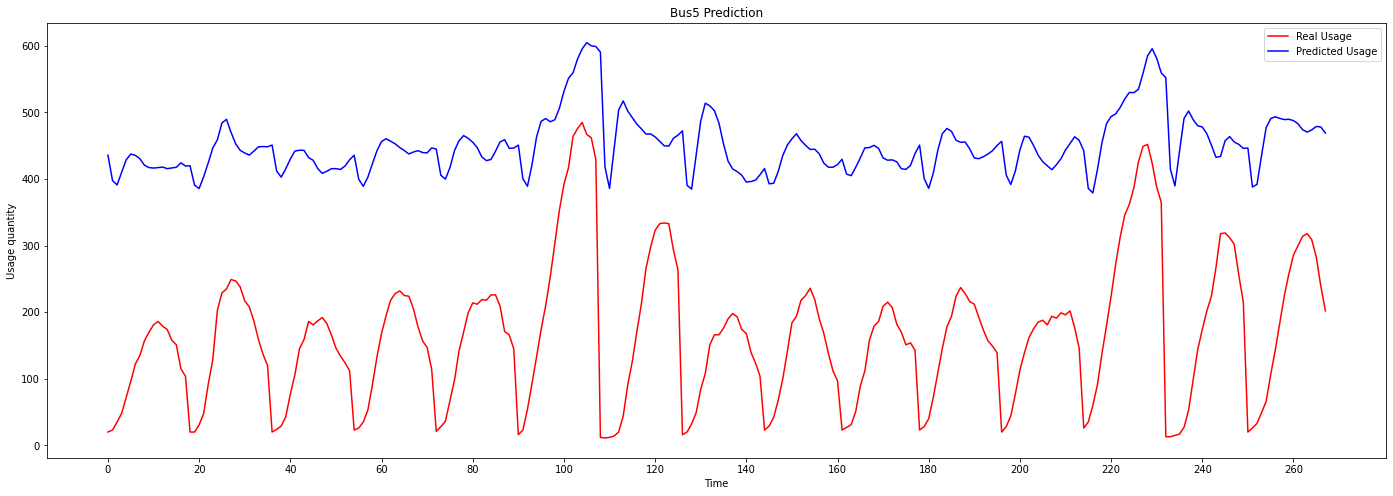

1/1 [==============================] - 0s 25ms/step


Text(0.5, 1.0, 'Bus5 Future Usage prediction')

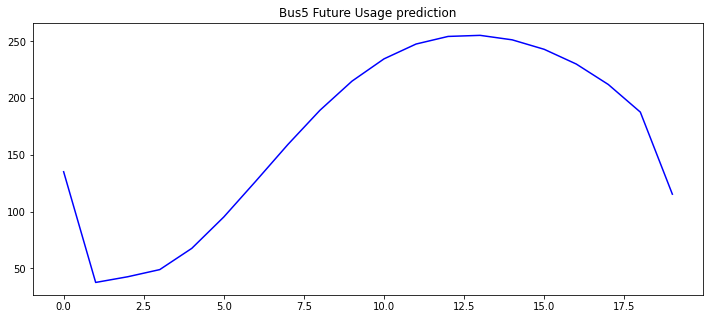

In [121]:
## BUS5
inputs = df_bus5[len(df_bus5) - len(test_bus5) - time_step:].values #*
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
test_size=len(df_bus5)-len(train_bus5) #*
X_test = []
for i in range(time_step,(time_step+test_size)):
    X_test.append(inputs[i-time_step:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

predicted_usage_number5= model5.predict(X_test) #*
predicted_usage_number5= scaler.inverse_transform(predicted_usage_number5) #*

# Visualising the results
plt.figure(figsize=(24,8))
plt.plot(test_bus5.values, color = "red", label ="Real Usage") #*
plt.plot(predicted_usage_number5, color = "blue", label = "Predicted Usage") #*
plt.xticks(np.arange(0,test_size,time_step))
plt.title('Bus5 Prediction') #*
plt.xlabel('Time')
plt.ylabel('Usage quantity')
plt.legend()
plt.show()

full_scaled_data=scaler.fit_transform(df_bus5) #*
forecast=[]
periods=20
n_features=1
first_eval_batch=full_scaled_data[-time_step:]
current_batch=first_eval_batch.reshape((1,time_step,n_features))

for i in range(periods):
    current_pred=model5.predict(current_batch)[0] #*
    forecast.append(current_pred)
    current_batch=np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

forecast5=scaler.inverse_transform(forecast)
plt.figure(figsize=(12,5))
plt.plot(forecast5,color="blue")
plt.title("Bus5 Future Usage prediction") #*

(268, 20, 1)
9/9 [==============================] - 0s 10ms/step


c:\users\developer\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


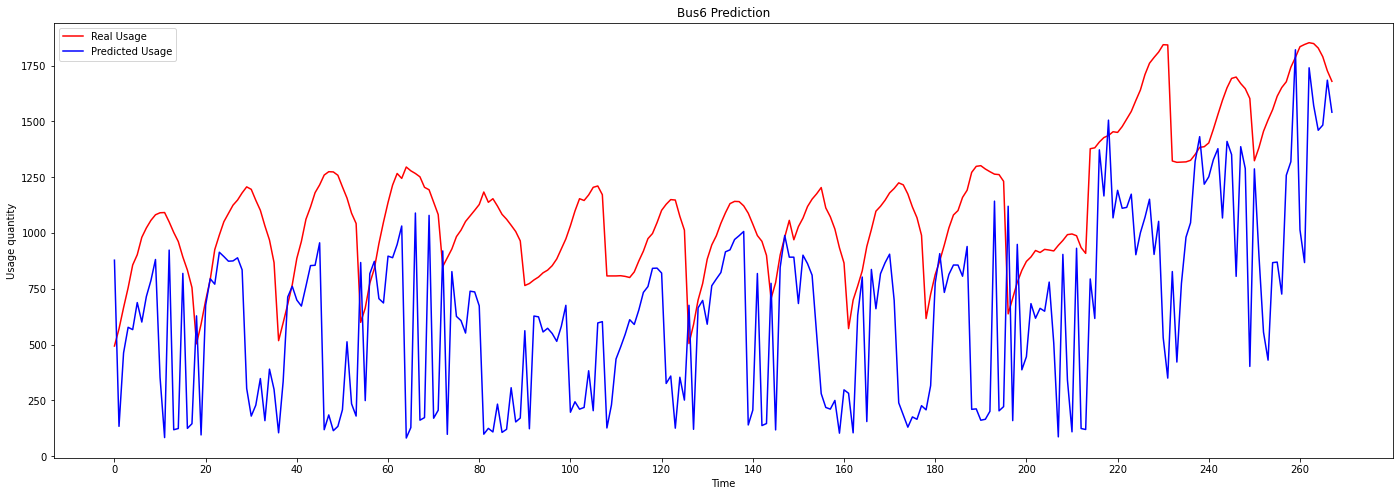

1/1 [==============================] - 0s 42ms/step


Text(0.5, 1.0, 'Bus6 Future Usage prediction')

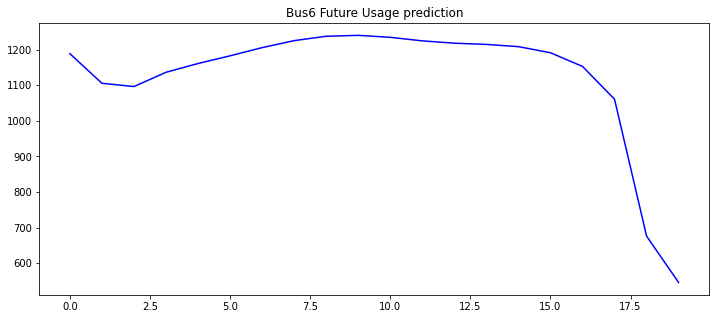

In [122]:
## BUS6
inputs = df_bus6[len(df_bus6) - len(test_bus6) - time_step:].values #*
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
test_size=len(df_bus6)-len(train_bus6) #*
X_test = []
for i in range(time_step,(time_step+test_size)):
    X_test.append(inputs[i-time_step:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

predicted_usage_number6= model6.predict(X_test) #*
predicted_usage_number6= scaler.inverse_transform(predicted_usage_number6) #*

# Visualising the results
plt.figure(figsize=(24,8))
plt.plot(test_bus6.values, color = "red", label ="Real Usage") #*
plt.plot(predicted_usage_number6, color = "blue", label = "Predicted Usage") #*
plt.xticks(np.arange(0,test_size,time_step))
plt.title('Bus6 Prediction') #*
plt.xlabel('Time')
plt.ylabel('Usage quantity')
plt.legend()
plt.show()

full_scaled_data=scaler.fit_transform(df_bus6) #*
forecast=[]
periods=20
n_features=1
first_eval_batch=full_scaled_data[-time_step:]
current_batch=first_eval_batch.reshape((1,time_step,n_features))

for i in range(periods):
    current_pred=model6.predict(current_batch)[0] #*
    forecast.append(current_pred)
    current_batch=np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

forecast6=scaler.inverse_transform(forecast)
plt.figure(figsize=(12,5))
plt.plot(forecast6,color="blue")
plt.title("Bus6 Future Usage prediction") #*

(268, 20, 1)
9/9 [==============================] - 0s 11ms/step


c:\users\developer\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


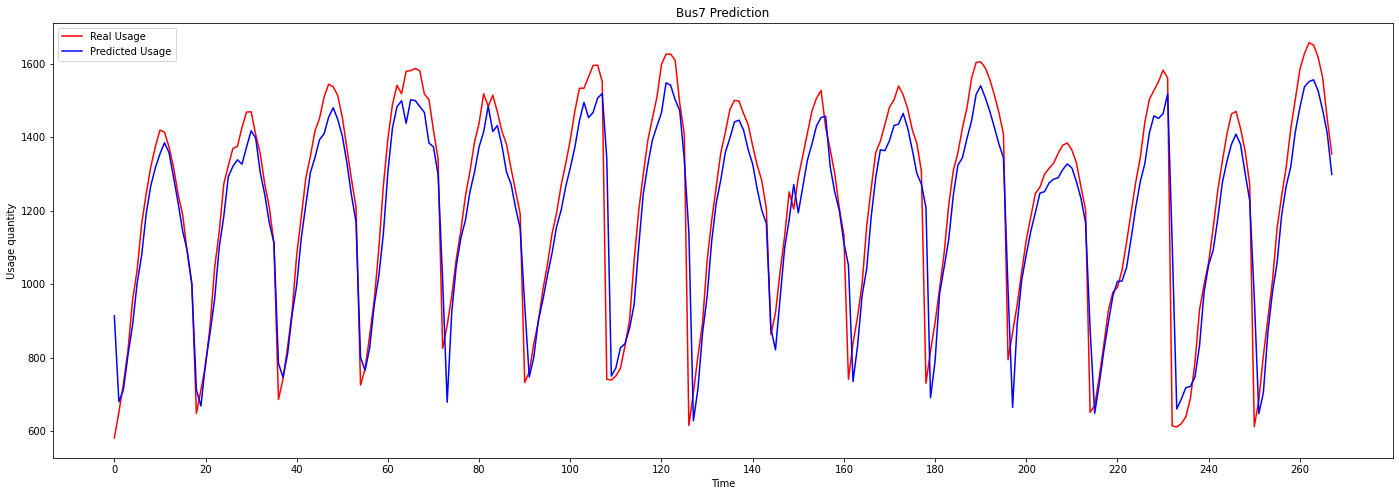

1/1 [==============================] - 0s 23ms/step


Text(0.5, 1.0, 'Bus7 Future Usage prediction')

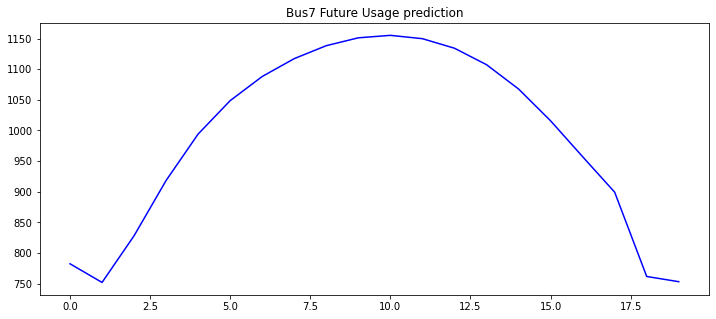

In [123]:
## BUS7
inputs = df_bus7[len(df_bus7) - len(test_bus7) - time_step:].values #*
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
test_size=len(df_bus7)-len(train_bus7) #*
X_test = []
for i in range(time_step,(time_step+test_size)):
    X_test.append(inputs[i-time_step:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

predicted_usage_number7= model7.predict(X_test) #*
predicted_usage_number7= scaler.inverse_transform(predicted_usage_number7) #*

# Visualising the results
plt.figure(figsize=(24,8))
plt.plot(test_bus7.values, color = "red", label ="Real Usage") #*
plt.plot(predicted_usage_number7, color = "blue", label = "Predicted Usage") #*
plt.xticks(np.arange(0,test_size,time_step))
plt.title('Bus7 Prediction') #*
plt.xlabel('Time')
plt.ylabel('Usage quantity')
plt.legend()
plt.show()

full_scaled_data=scaler.fit_transform(df_bus7) #*
forecast=[]
periods=20
n_features=1
first_eval_batch=full_scaled_data[-time_step:]
current_batch=first_eval_batch.reshape((1,time_step,n_features))

for i in range(periods):
    current_pred=model7.predict(current_batch)[0] #*
    forecast.append(current_pred)
    current_batch=np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

forecast7=scaler.inverse_transform(forecast)
plt.figure(figsize=(12,5))
plt.plot(forecast7,color="blue")
plt.title("Bus7 Future Usage prediction") #*

(268, 20, 1)
9/9 [==============================] - 0s 11ms/step


c:\users\developer\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


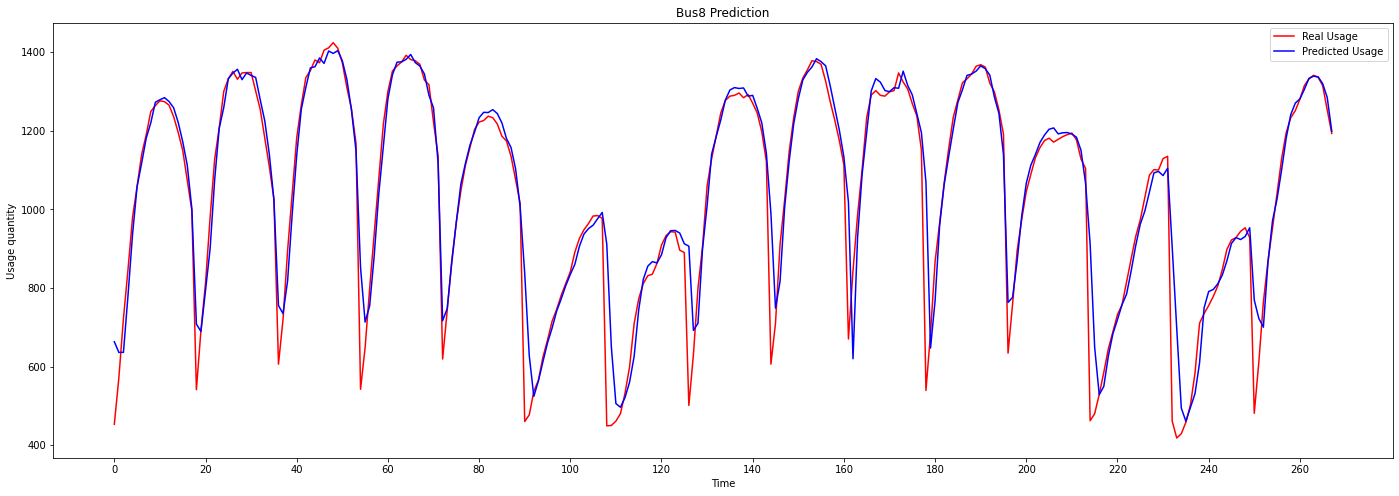

1/1 [==============================] - 0s 36ms/step


Text(0.5, 1.0, 'Bus8 Future Usage prediction')

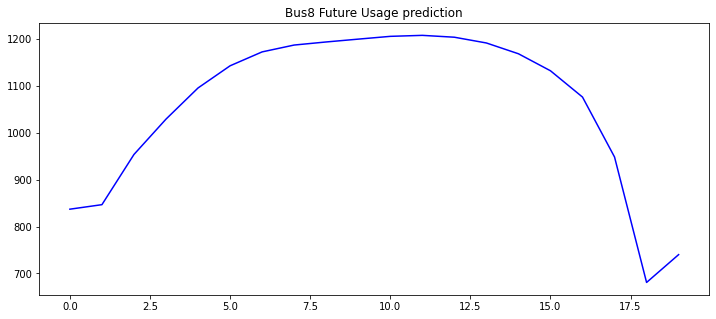

In [124]:
## BUS8
inputs = df_bus8[len(df_bus8) - len(test_bus8) - time_step:].values #*
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
test_size=len(df_bus8)-len(train_bus8) #*
X_test = []
for i in range(time_step,(time_step+test_size)):
    X_test.append(inputs[i-time_step:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

predicted_usage_number8= model8.predict(X_test) #*
predicted_usage_number8= scaler.inverse_transform(predicted_usage_number8) #*

# Visualising the results
plt.figure(figsize=(24,8))
plt.plot(test_bus8.values, color = "red", label ="Real Usage") #*
plt.plot(predicted_usage_number8, color = "blue", label = "Predicted Usage") #*
plt.xticks(np.arange(0,test_size,time_step))
plt.title('Bus8 Prediction') #*
plt.xlabel('Time')
plt.ylabel('Usage quantity')
plt.legend()
plt.show()

full_scaled_data=scaler.fit_transform(df_bus8) #*
forecast=[]
periods=20
n_features=1
first_eval_batch=full_scaled_data[-time_step:]
current_batch=first_eval_batch.reshape((1,time_step,n_features))

for i in range(periods):
    current_pred=model8.predict(current_batch)[0] #*
    forecast.append(current_pred)
    current_batch=np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

forecast8=scaler.inverse_transform(forecast)
plt.figure(figsize=(12,5))
plt.plot(forecast8,color="blue")
plt.title("Bus8 Future Usage prediction") #*

(268, 20, 1)
9/9 [==============================] - 0s 9ms/step


c:\users\developer\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


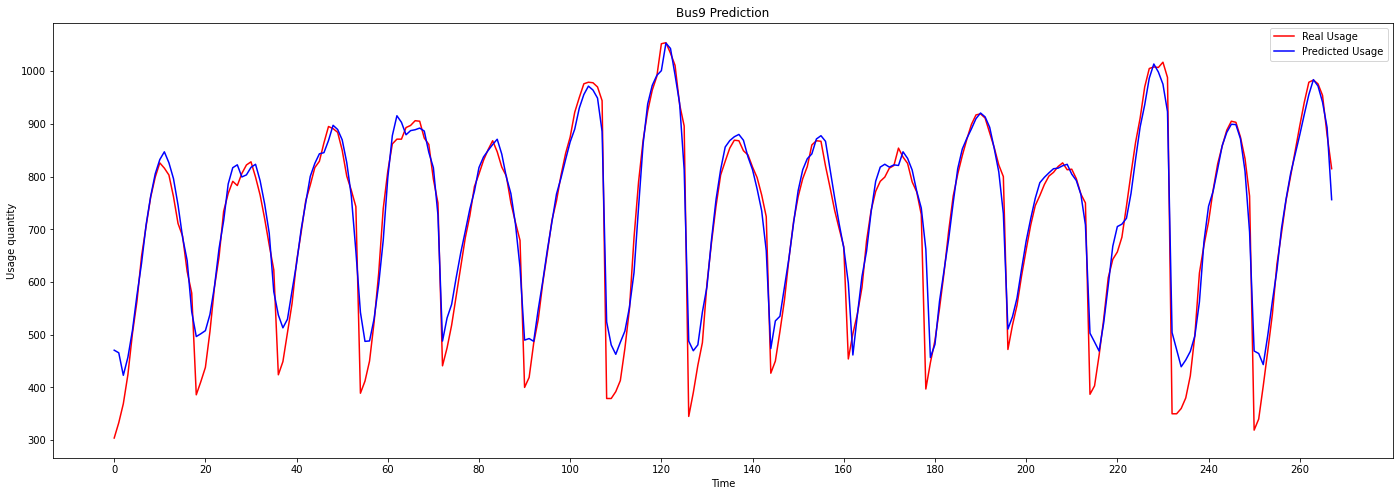

1/1 [==============================] - 0s 21ms/step


Text(0.5, 1.0, 'Bus9 Future Usage prediction')

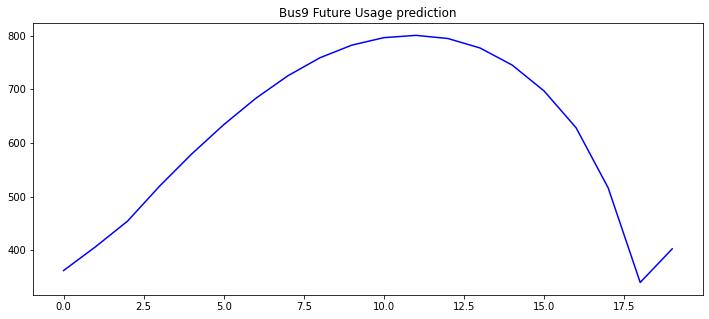

In [125]:
## BUS9
inputs = df_bus9[len(df_bus9) - len(test_bus9) - time_step:].values #*
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
test_size=len(df_bus9)-len(train_bus9) #*
X_test = []
for i in range(time_step,(time_step+test_size)):
    X_test.append(inputs[i-time_step:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

predicted_usage_number9= model9.predict(X_test) #*
predicted_usage_number9= scaler.inverse_transform(predicted_usage_number9) #*

# Visualising the results
plt.figure(figsize=(24,8))
plt.plot(test_bus9.values, color = "red", label ="Real Usage") #*
plt.plot(predicted_usage_number9, color = "blue", label = "Predicted Usage") #*
plt.xticks(np.arange(0,test_size,time_step))
plt.title('Bus9 Prediction') #*
plt.xlabel('Time')
plt.ylabel('Usage quantity')
plt.legend()
plt.show()

full_scaled_data=scaler.fit_transform(df_bus9) #*
forecast=[]
periods=20
n_features=1
first_eval_batch=full_scaled_data[-time_step:]
current_batch=first_eval_batch.reshape((1,time_step,n_features))

for i in range(periods):
    current_pred=model9.predict(current_batch)[0] #*
    forecast.append(current_pred)
    current_batch=np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

forecast9=scaler.inverse_transform(forecast)
plt.figure(figsize=(12,5))
plt.plot(forecast9,color="blue")
plt.title("Bus9 Future Usage prediction") #*

### RESULTS

In [134]:
Future_forecast=pd.DataFrame(data=forecast0,columns=["Bus0 Future prediction"])
Future_forecast["Bus1 Future prediction"]=forecast1
Future_forecast["Bus2 Future prediction"]=forecast2
Future_forecast["Bus3 Future prediction"]=forecast3
Future_forecast["Bus4 Future prediction"]=forecast4
Future_forecast["Bus5 Future prediction"]=forecast5
Future_forecast["Bus6 Future prediction"]=forecast6
Future_forecast["Bus7 Future prediction"]=forecast7
Future_forecast["Bus8 Future prediction"]=forecast8
Future_forecast["Bus9 Future prediction"]=forecast9
Future_forecast

,Bus0 Future prediction,Bus1 Future prediction,Bus2 Future prediction,Bus3 Future prediction,Bus4 Future prediction,Bus5 Future prediction,Bus6 Future prediction,Bus7 Future prediction,Bus8 Future prediction,Bus9 Future prediction
0,1089.302689,163.054087,371.773640,598.436095,1342.342085,135.077839,1188.564261,782.456913,836.939737,362.189427
1,872.461215,177.027628,373.845259,690.143687,1580.263622,37.545143,1105.412315,751.985123,846.563755,406.585643
2,728.838709,209.895231,392.329596,839.858358,1818.839734,42.558465,1096.196499,828.227372,953.618307,454.371982
3,658.582124,252.461963,412.405226,998.420390,2006.645913,48.859506,1136.251401,918.475713,1028.998456,519.543673
4,639.170339,296.176201,430.834729,1120.205982,2161.250063,67.577962,1160.907566,994.264540,1095.449978,579.319536
5,647.746914,332.440088,445.701728,1193.572999,2268.590717,95.244865,1182.522768,1048.770592,1142.709935,633.938112
6,667.467059,358.087167,459.664545,1236.827410,2356.303124,126.865417,1205.474641,1088.179947,1172.372242,682.958567
7,689.389092,372.261375,474.167649,1260.790891,2439.578742,159.101257,1225.124181,1117.325153,1186.984655,724.957402
8,712.231082,376.493653,487.447167,1274.289691,2510.491398,189.233856,1237.343065,1138.451595,1193.549699,758.483519
9,733.904551,373.897846,498.961365,1282.832548,2566.256619,214.892585,1239.945241,1151.261904,1199.594520,782.167021
